In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append("..")
from results import get_df, get_stats, final_plot
import input_pipeline
import pandas as pd
import seaborn as sns
from model import CVAE
plt.rcParams['figure.dpi'] = 300

2024-03-22 08:46:07.815686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Sampling

In [2]:
def sample(num_examples_to_generate, model, temp_vector, latent_dim = 200):
    random_mean = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
    z = model.reparameterize(random_mean, log_var)
    z_t = tf.concat([z, temp_vector], axis=1)
    predictions = model.sample(z_t)
    return predictions

def load_model_weights(path, latent_dim = 200, num_classes = 11):
    model = CVAE(latent_dim, num_classes)
    img = tf.zeros((1, 32, 32, 1))
    temp = tf.zeros((1, num_classes))
    dummy_input = (img, temp)
    model(dummy_input)
    model.load_weights(path)
    return model

def random_swap(data):
    data = tf.reshape(data, shape = (data.shape[0], -1))
    swap_mask = 2 * (np.random.random(size = (data.shape[0], 1)) > 0.5) - 1
    data = tf.multiply(data, swap_mask)
    data = tf.reshape(data, shape = (-1, 32, 32, 1))
    return data

In [3]:
from tensorflow.keras.models import load_model

classifier = load_model("results/classifier")
classifier.summary()

2024-03-22 08:46:11.427762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11551 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0

In [4]:
temps = [1.5, 2.0, 2.5, 2.7, 3.0, 4.0]
model = load_model_weights("../../GetData/Python/Data/Results/cvae/2024-03-22_07-09/cvae.h5", 200,len(temps))

2024-03-22 08:46:13.059773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


Text(0.5, 0.98, 'Ising configurations generated by CVAE model')

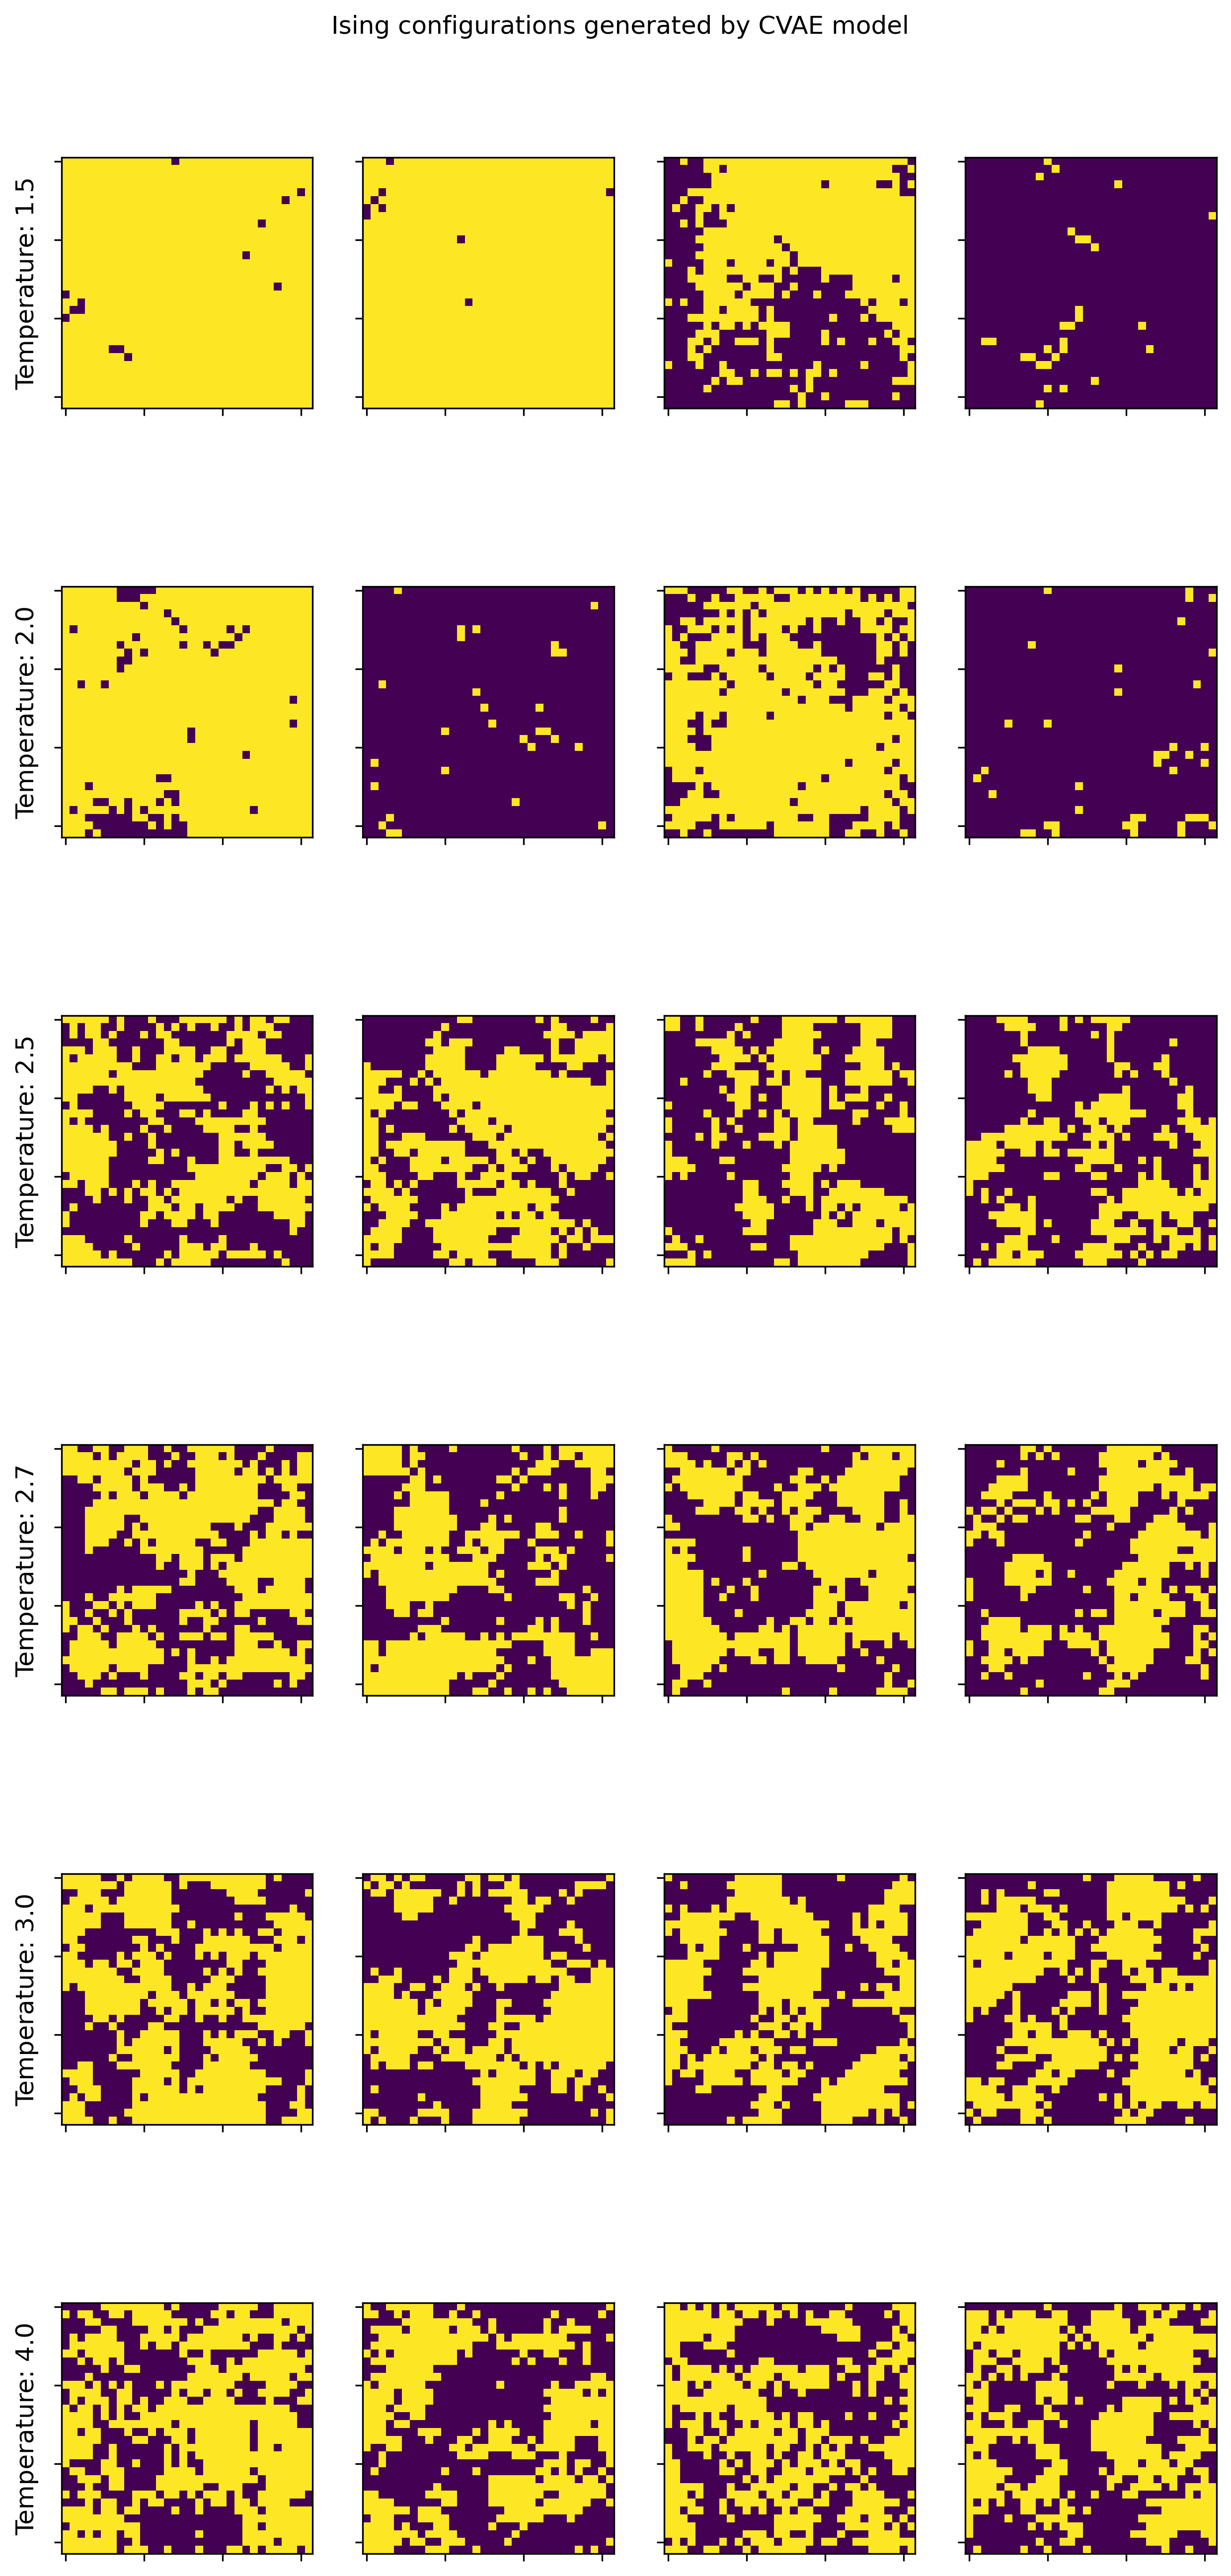

In [19]:
fig, axes = plt.subplots(nrows=len(temps), ncols=4, figsize=(10, 20))
titles = [f"Temperature: {t:.2}" for t in temps]

plt.subplots_adjust(top=0.95)  # Add space at the top

for i, ax_row in enumerate(axes):
    ax_row[0].set_ylabel(titles[i], rotation=90, size='large')
    temp_vector = np.zeros((5, len(temps)))
    temp_vector[:, i] = 1
    predictions = sample(5, model, temp_vector)
    for j, ax in enumerate(ax_row):
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = np.random.binomial(1, predictions[j, :, :])
        ax.imshow(spins, vmin=0, vmax=1)

plt.suptitle("Ising configurations generated by CVAE model")


In [5]:
data_list = []
for i, temp in enumerate(temps):
    # Monte Carlo
    trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
    batch_size = 10000
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
    data_mc = next(iter(train_set))
    data_mc = 2 * data_mc - 1
    df_monte_carlo = get_df(data_mc)
    mc_stats = get_stats(df_monte_carlo, temp)
    mc_stats.extend((temp, "Monte Carlo"))

    # Sampled from CVAE
    temp_vector = np.zeros((100, len(temps)))
    temp_vector[:, i] = 1
    sample_data = []
    for _ in range(500):
        spin_sample = sample(100, model, temp_vector)
        spin_sample = 2 * np.random.binomial(1, spin_sample) - 1
        spin_sample = random_swap(spin_sample)
        logits = classifier(spin_sample)
        class_predicted = tf.math.argmax(logits, axis = 1)
        correct_sample = spin_sample[class_predicted == i]
        sample_data.append(correct_sample)

    sample_data = tf.concat(sample_data, axis = 0)
    df_sampled = get_df(sample_data)
    sample_stats = get_stats(df_sampled, temp)
    sample_stats.extend((temp, "Sampled CVAE"))
    data_list.append(mc_stats)
    data_list.append(sample_stats)

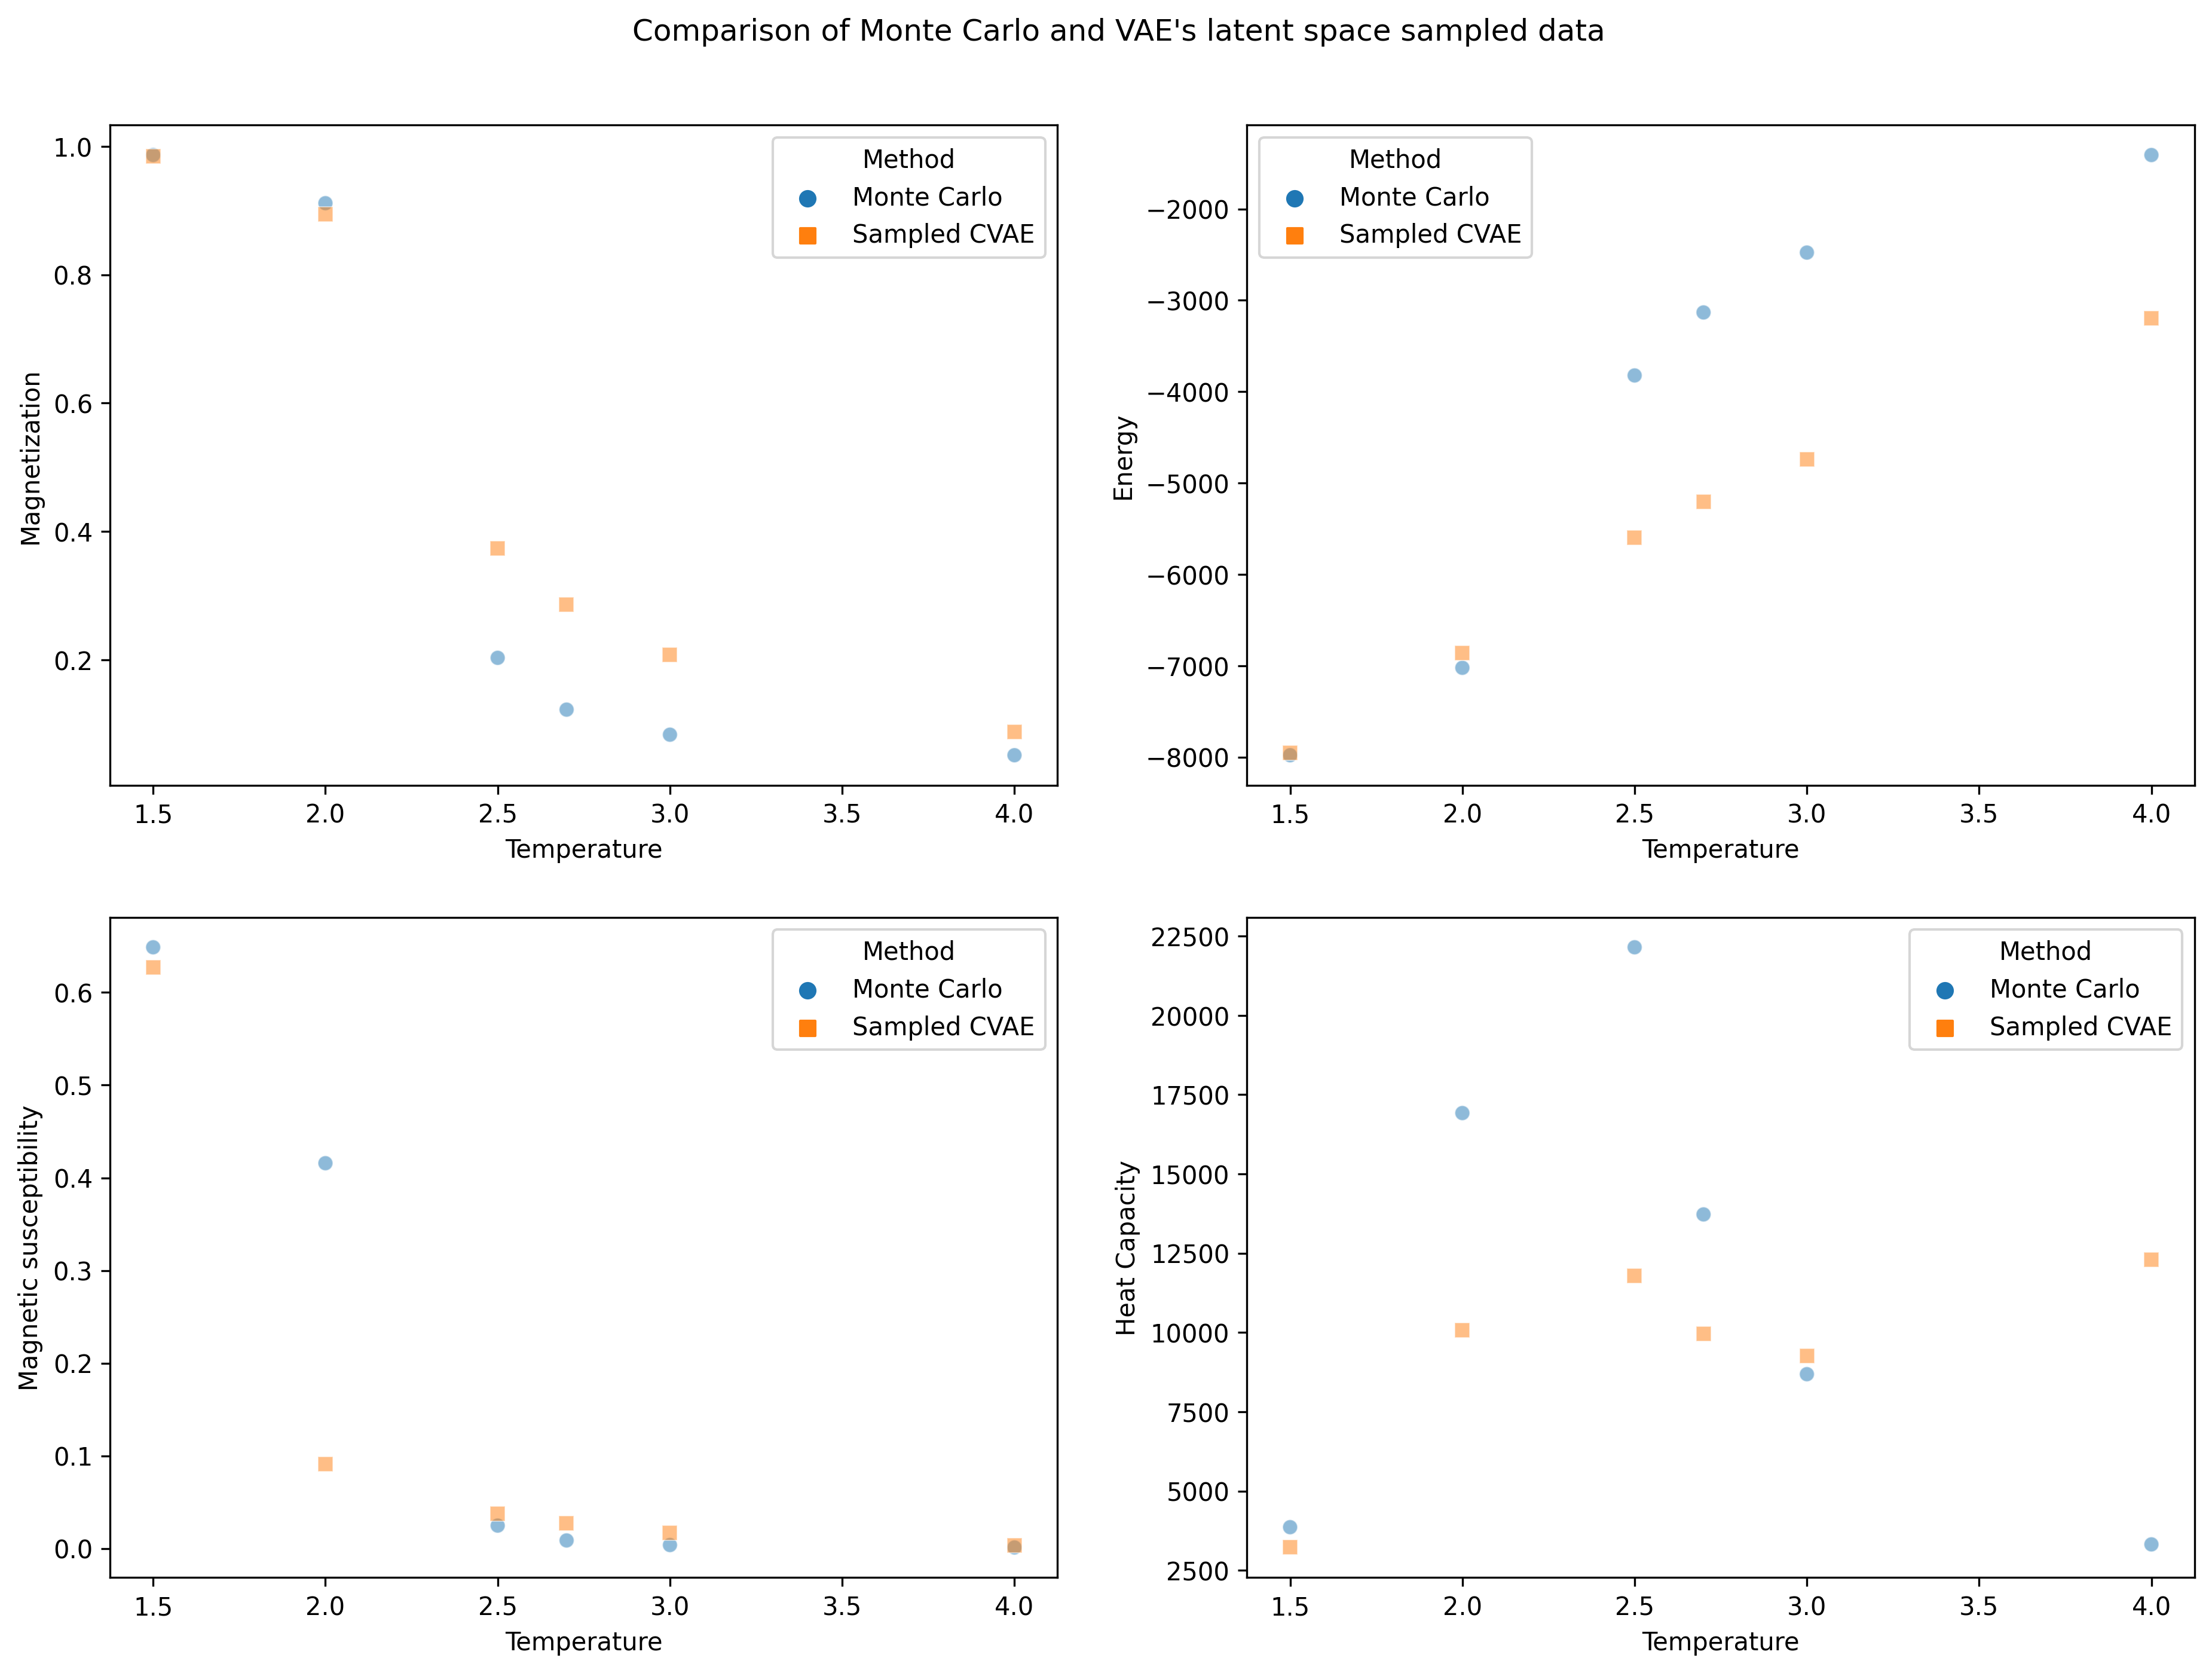

In [6]:
final_plot(data_list)
plt.savefig("cvae_result.png")